# Week 9: Residual networks

## General instructions

Each week you will be given an assignment related to the associated module. You have roughly one week to complete and submit each of them. There are 3 weekly group sessions available to help you complete the assignments. Attendance is not mandatory but recommended. However, assignments are graded each week and not submitting them or submitting them after the deadline will give you no points.

**FORMAT**: Jupyter notebook **(single file, not in a zip please!)**

**DEADLINE**: Sunday 7th March, 23:59

## Introduction

The objective of this assignment is to get a better intuition as to why residual networks work in practice. More particularly, we will investigate how adding skip connections to a feeforward neural network affects its gradient when combined with carefull initialization of the weights and biases and batch normalization. In all the present work, **we will solely investigate networks' initialization, that is the statistics of sampled neural networks without any training.** We will in particular emphasize how the depth of feedforward neural networks tends to "break" the gradients, which is known to make training much more difficult. 

Observing the gradients is made difficult by the fact that a neural network typically has many variables. To tackle this problem, rather than computing the gradients with respect to the network's parameters as you are now used to, we will instead compute the gradients with respect to the input data. This is meaningful since by the chain rule, the derivatives with respect to inputs are connected to the derivatives with respect to parameters. Furthermore, we will investigate a neural network $x \mapsto f(x)$ mapping $\mathbb{R}$ to $\mathbb{R}$, making it convenient for us to investigate the one dimensional derivatives with respect to inputs. Since we are interested in observing how network depth negatively affects the structure of gradients, we will use a simple grid of uniformly spaced data points ranging from -1 to 1 as input for our network. The exact structure of the neural network is given in the image below:

![title](a_simple_NN-1.png)


Your task is to complete all the cells from the notebook (more detailed instructions are provided in each cell). **In the last cell, you will be asked to provide a thorough visualization (with plots !) and analysis of your experiments. Do not take this lightly as it will be the most important aspect for the grading.**


## Andrew's Videos related to this week's assignment

- [C4W2L03 ResNets](https://www.youtube.com/watch?v=ZILIbUvp5lk&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=14)
- [C4W2L04 Why ResNets work](https://www.youtube.com/watch?v=RYth6EbBUqM&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=15)

## Going further

- https://arxiv.org/pdf/1702.08591.pdf
- https://arxiv.org/pdf/1805.07477.pdf


# Setup

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn  as sns

torch.backends.cudnn.benchmark = True

# Utility functions

(You will use these later !)

In [7]:
def compute_correlation(array):
    correlation = np.corrcoef(array, rowvar=False)
    autocorrelation = correlation[:,0]
    return correlation, autocorrelation

def visualize_white_noise(num_vars, num_samples, figsize, color):
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle("White noise: " + "$w_n \\sim \\mathcal{N}(0,\\sigma)\\quad \\forall n$")
    white_noise = np.random.randn(num_samples, num_vars)
    correlation, autocorrelation = compute_correlation(white_noise)
    axes[0].plot(np.arange(num_vars), white_noise.mean(axis=0), color=color)
    axes[1].plot(np.arange(num_vars), autocorrelation, color=color)
    sns.heatmap(correlation, cbar=True, xticklabels=False, yticklabels=False, ax=axes[2])
    axes[0].set_title("Mean")
    axes[1].set_title("Autocorrelation function")
    axes[2].set_title("Correlation matrix")
    axes[0].set_xlabel("n", fontsize="x-large")
    axes[1].set_xlabel("k", fontsize="x-large")
    axes[0].set_ylabel("$E(w_n)$", fontsize="x-large")
    axes[1].set_ylabel("$\\rho_w(0,0+k)$", fontsize="x-large")
    plt.show()

# Gradient computation

In [8]:
def compute_gradient_wrt_input(neural_network, x):
    '''
    
    Input: 
        -neural_network: a neural network f
        -x: input data x=[x1,...,xk] (1D tensor)
        
    Output:
        -gradient: the gradient of the neural network wrt x, df/dx=[df/dx1,...,df/dxk]
        
    TODO: 
    1) Disable autograd for all the network's parameters.
    2) Enable autograd for x.
    3) Implement a forward pass followed by a backward pass on the neural network with input data x.
    4) Collect the gradient of the neural network in x.
    
    Note: We do not want to update the parameters of the neural network, thus we don't need an optimizer.
    
    '''
    # 1) Disable autograd for all the network's parameters.
    for p in neural_network.parameters():
        p.requires_grad = False
    # neural_network.requires_grad = False # is this not enough?

    # 2) Enable autograd for x.
    x.requires_grad = True

    # 3) Implement a forward pass followed by a backward pass on the neural network with input data x.
    out = neural_network.forward(x).sum()
    out.backward()

    # 4) Collect the gradient of the neural network in x.
    return x.grad

In [9]:
# t = compute_gradient_wrt_input(model, torch.linspace(-1, 1, 10))
# print(t.size())
# t

torch.Size([10])


tensor([-0.4248, -0.0226,  0.8997, -1.9051,  0.7204,  1.2415,  0.0661,  0.6516,
        -1.0343, -0.1925])

# Residual neural network

In [10]:
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0, np.sqrt(1/m.in_features))
        m.bias.data.normal_(0, np.sqrt(1/m.in_features))
    if type(m) == nn.BatchNorm1d:
        m.weight.data.normal_(0, np.sqrt(1/m.num_features))
        m.bias.data.normal_(0, np.sqrt(1/m.num_features))

class residual1D(nn.Module):
    '''
    
    TODO:
    1) Construct a feedforward neural network consisting of d layers such that:
        -Each layer is exactly "linear->batch_norm1d->ReLU".
        -Layer 0 has in_features=1, out_features=n.
        -Layers 1 to d-2 have in_features=n, out_features=n.
        -Layer d-1 has in_features=n, out_features=1.
        -Each layer has its linear component initialized such that weight, bias ~ N(0,sigma²=1/in_features) 
    2) Implement the forward function of the neural network: a_{l+1} = layer_l(a_l), (a_0 = x).
    3) Implement an alternative forward pass with skip connections: a_{l+1} = a_l + beta * layer_l(a_l), (a_0 = x).
    
    '''
    
    def __init__(self, d, n, beta, network_type="feedforward"):
        super(residual1D, self).__init__()
        self.network_type = network_type
        self.layers = d
        self.beta = beta
        
        out_features = n
        
        # Layer 0 has in_features=1, out_features=n.        
        self.layer0 = nn.Sequential(
                            nn.Linear(1, n), 
                            nn.BatchNorm1d(n), 
                            nn.ReLU() )

        # Layers 1 to d-2 have in_features=n, out_features=n.
        for i in range(1, d):
            # Layer d-1 has in_features=n, out_features=1.
            if i == d-1:
                out_features = 1
            setattr(self, 'layer' + str(i), nn.Sequential(
                                                nn.Linear(n, n), 
                                                nn.BatchNorm1d(n), 
                                                nn.ReLU() ))
        
        # Each layer has its linear component initialized such that weight, bias ~ N(0,sigma²=1/in_features) 
        self.apply(init_weights)


    def forward(self, x):
        out = x.view(-1, 1)
        # 3) Implement an alternative forward pass with skip connections: a_{l+1} = a_l + beta * layer_l(a_l), (a_0 = x).
        if self.network_type == "residual":
            for l in range(self.layers):
                # out += self.beta * getattr(self, 'layer' + str(l))(out)         # why this does not work :-(
                out = out + self.beta * getattr(self, 'layer' + str(l))(out)
            return out

        # 2) Implement the forward function of the neural network: a_{l+1} = layer_l(a_l), (a_0 = x).
        for l in range(self.layers):
            out = getattr(self, 'layer' + str(l))(out)
        return out

model = residual1D(5, 10, 0.1)
print(model)

residual1D(
  (layer0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)


# Experiment code

In [17]:
def visualize_cor(array, depth, network_type, beta=0.01, figsize=(18, 5), color='blue'):
    num_samples, num_vars = array.shape
    # print("num_vars", num_vars)
    # print("num_samples", num_samples)

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle("Gradients for depth=" + str(depth) + ", network type=" + network_type + ", beta=" + str(beta))
    correlation, autocorrelation = compute_correlation(array)
    axes[0].plot(np.arange(num_vars), array.mean(axis=0), color=color)
    axes[1].plot(np.arange(num_vars), autocorrelation, color=color)
    sns.heatmap(correlation, cbar=True, xticklabels=False, yticklabels=False, ax=axes[2])
    axes[0].set_title("Mean")
    axes[1].set_title("Autocorrelation function")
    axes[2].set_title("Correlation matrix")
    axes[0].set_xlabel("n", fontsize="x-large")
    axes[1].set_xlabel("k", fontsize="x-large")
    axes[0].set_ylabel("$E(w_n)$", fontsize="x-large")
    axes[1].set_ylabel("$\\rho_w(0,0+k)$", fontsize="x-large")
    plt.show()

In [18]:
def inspect_gradients(network_type, x, depths, num_iters, beta=0.2, seed=42):
    '''
    Input:
        -network_type: type of neural network (either "feedforward" or "residual")
        -x: input data x=[x1,...,xk] (1D tensor)
        -depths: network depths to inspect
        -num_iters: number of iterations (number of random sampling of neural networks)
        -seed: self-explanatory
    
    TODO: 
    1) Seed pytorch
    2) For every depth, for every iteration:
        -Initialize a neural network of the desired type ("feedforward" or "residual") and depth.
        -Compute and store the gradient of the sampled network wrt x.
        -Stack the computed gradient vertically inside an array of shape [num_iters, X.shape[0]].
    3) For every depth:
        -Extract the mean of the gradients (with respect to the iterations).
        -Extract the correlation matrix and the autocorrelation function of the gradients.
    4) Visualize the statistics extracted in 3).
    
    Note: For 3) and 4), see Utility functions.
    
    '''
    # 1) Seed pytorch
    torch.manual_seed(seed)

    # 2) 
    for d in depths:
        gradients = torch.zeros(num_iters, x.shape[0])
        for i in range(num_iters):
            model = residual1D(d=d, n=100, beta=beta, network_type=network_type)
            g = compute_gradient_wrt_input(model, x)
            gradients[i] = g
    # 3) 
        visualize_cor(gradients, depth=d, network_type=network_type, beta=beta)


# Experiments and analysis

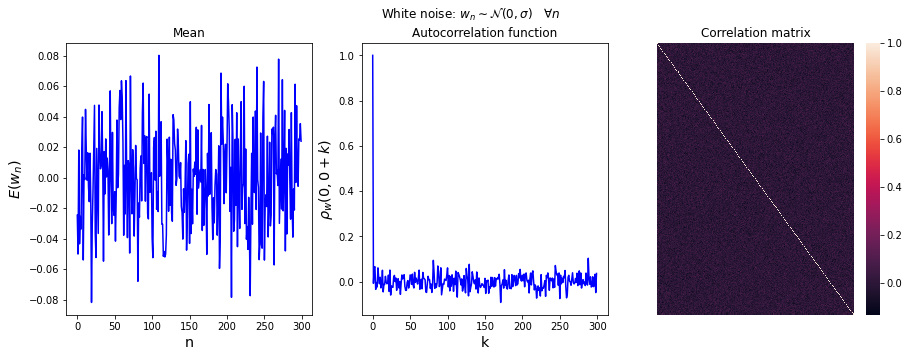

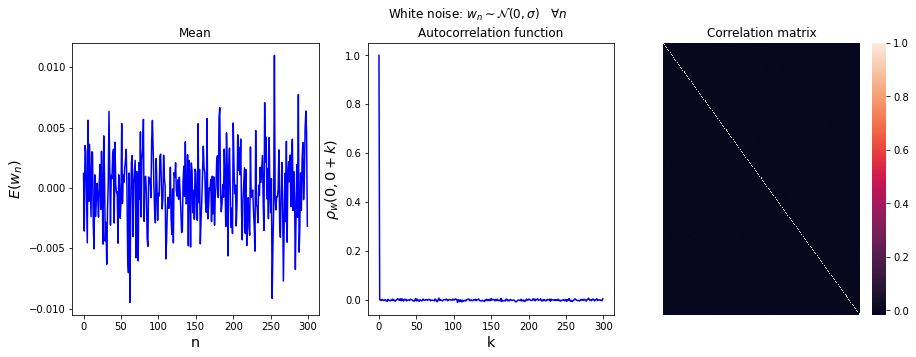

In [30]:
'''
TODO:
1) Visualize white noise.
2) Create a 1D data tensor x consisting of (>= 100) points uniformly spaced between [-1,1]
3) Visualize gradients wrt x of feedforward neural networks with various depths.
4) Visualize gradients wrt x of residual neural networks with various depths.
5) ANALYSIS OF YOUR RESULTS (in a markdown cell): 
    -Give two problems occuring with the gradients of deep feedforward neural networks at initialization.
    -From the observation of your plots, to which extent these problems were solved by 
     the combination of proper initialization + batch normalization + skip connections ?
    -What is the maximal depth you can reach with your feedforward network before "breaking" the gradients ?
    -Same question with your residual network.
    -What is the effect of the parameter beta in your residual neural network ?
    
'''
# 1) Visualize white noise.
visualize_white_noise(num_vars=300, num_samples=1_000, figsize=(15, 5), color='blue')
visualize_white_noise(num_vars=300, num_samples=100_000, figsize=(15, 5), color='blue')


For white noise, there is typical **impulse** at lag 0 (it is more clear for higher number of samples).

The values of mean for higher number of samples are **closer to zero** (less variance), which is obvious.

Correlation matrix is almost zero everywhere, that means there is **no** correlation.

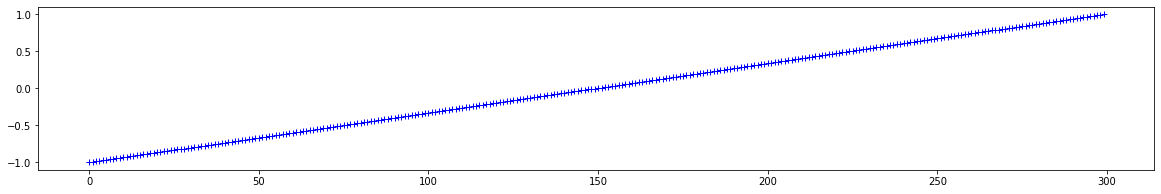

In [25]:
# 2) Create a 1D data tensor x consisting of (>= 100) points uniformly spaced between [-1,1]
plt.figure(figsize=(20, 3))
plt.plot(torch.linspace(-1, 1, 300).detach().numpy(), 'b+')
plt.show()

# I am using 1000 points, however, I plotted only 300 (for clarity).
x = torch.linspace(-1, 1, 1000)

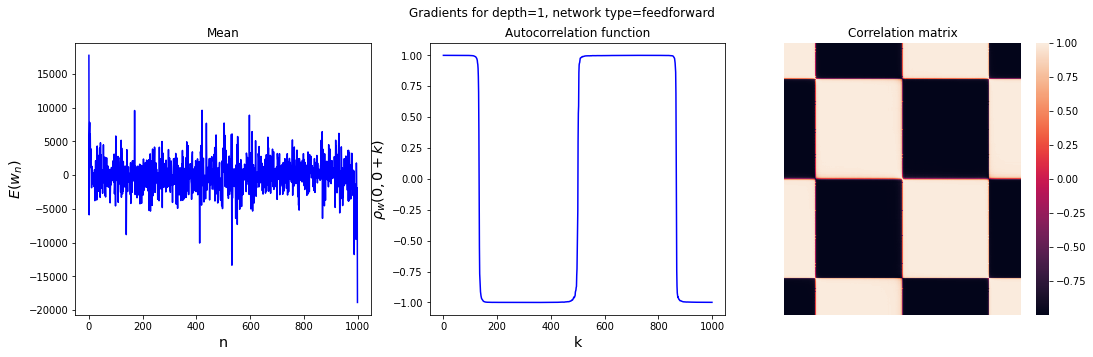

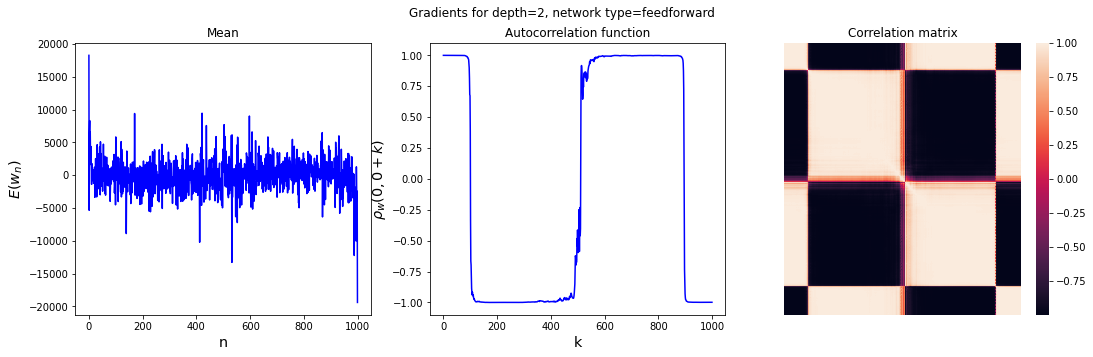

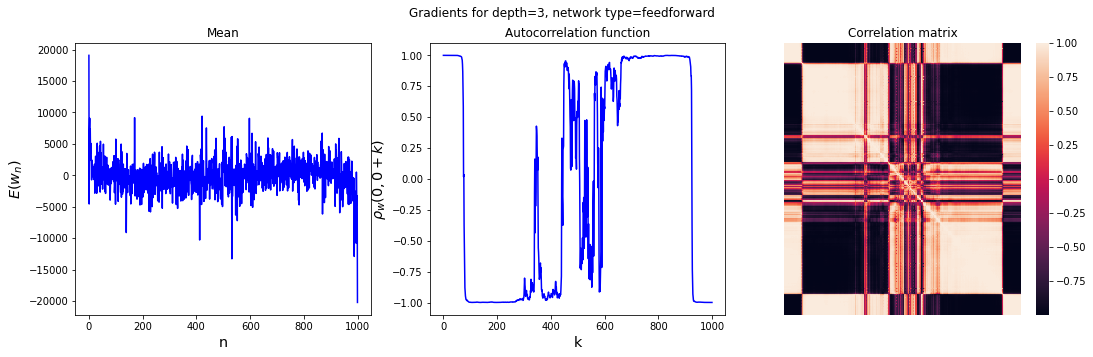

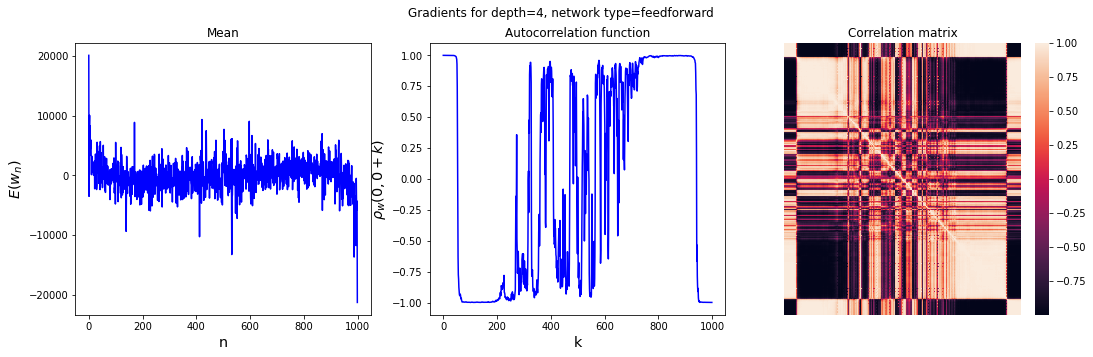

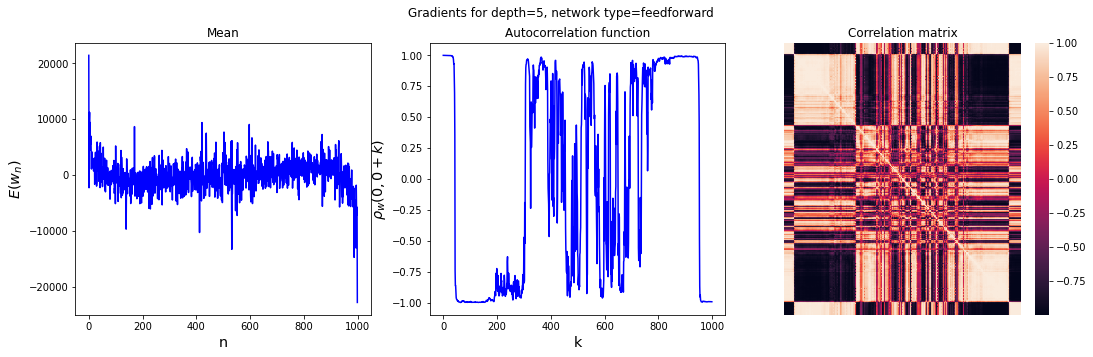

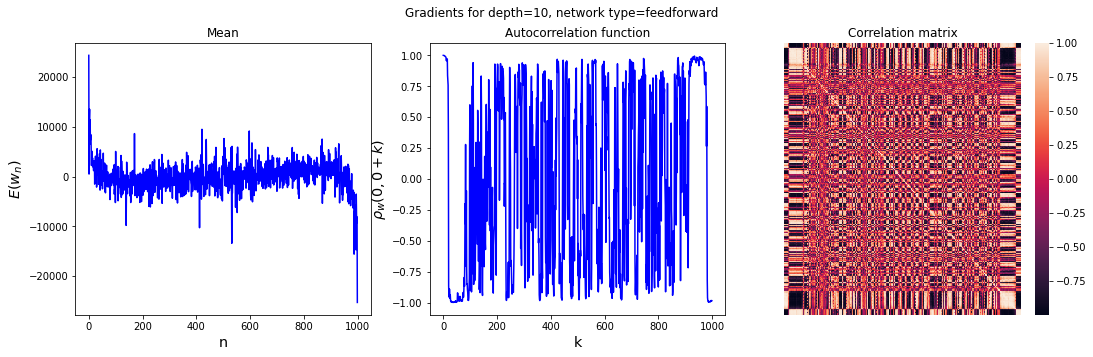

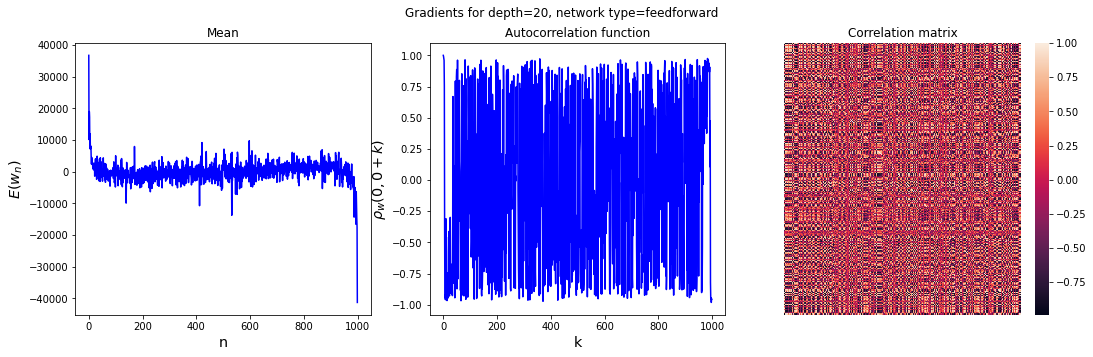

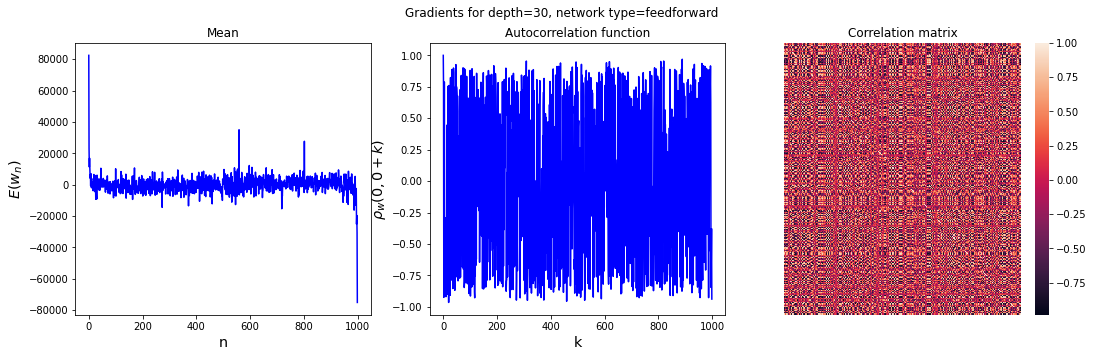

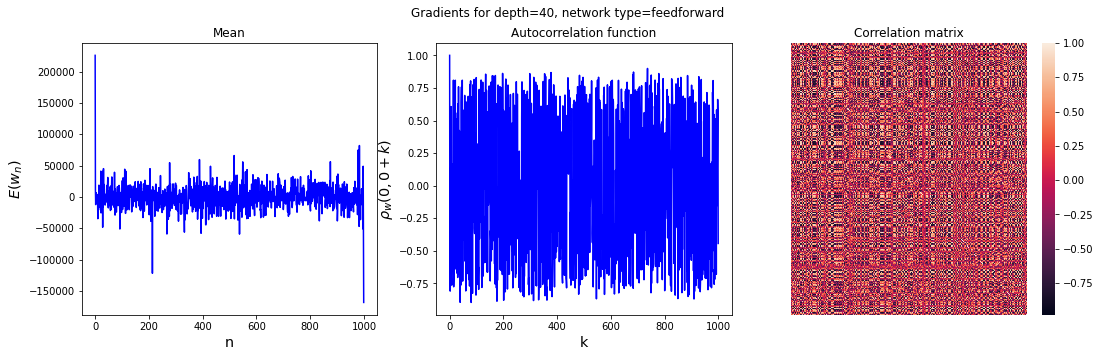

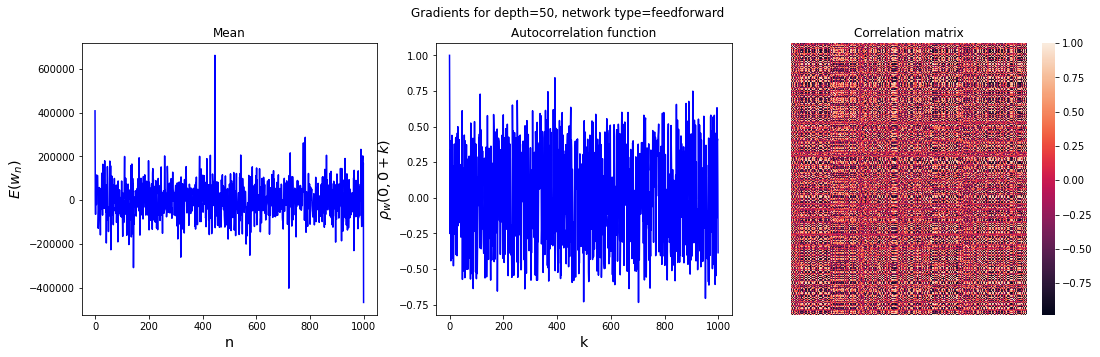

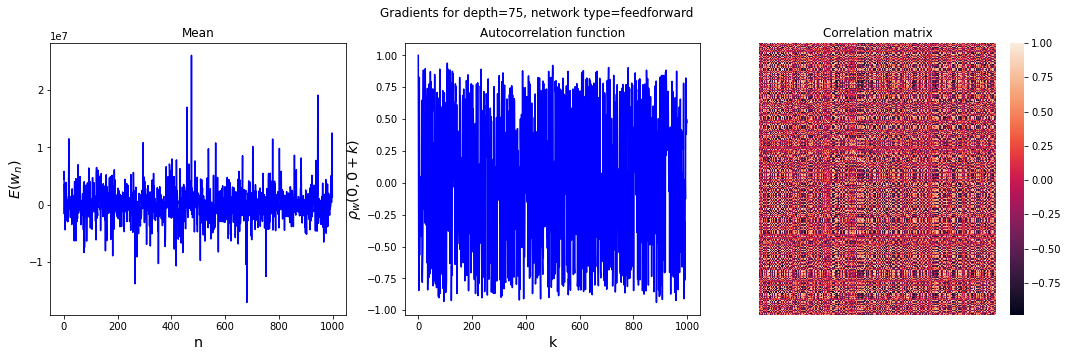

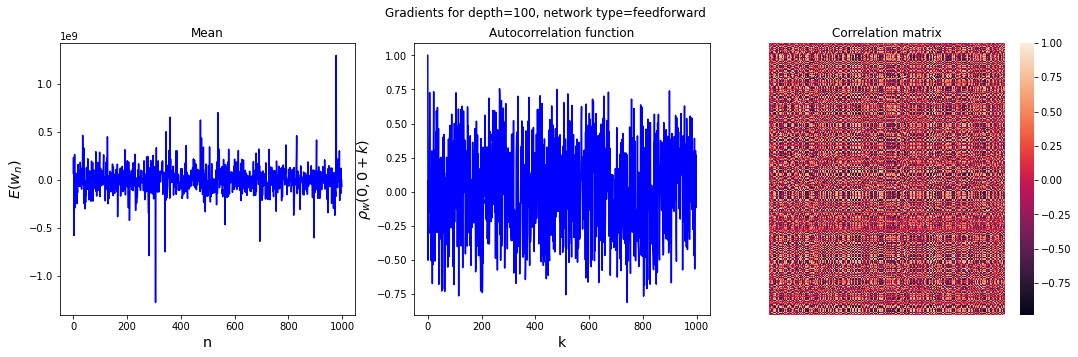

CPU times: user 8min 13s, sys: 16.6 s, total: 8min 30s
Wall time: 8min 30s


In [ ]:
%%time
x = torch.linspace(-1, 1, 1000)
# 3) Visualize gradients wrt x of feedforward neural networks with various depths.
inspect_gradients(network_type="feedforward", x=x, depths=[1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 75, 100], num_iters=300)

### Network type - feedforward
- With increasing depths:
    - we can observe that the autocorelation function is **more noisy**.
    - Variance of the means is **higher** (i.e. maxima and minima are higher in absolute value).
- For lower depths:
    - The correlation (positive as well as negative) is present.
    - Autocorelation plot shows only few impulses (from positive to negative correlation).

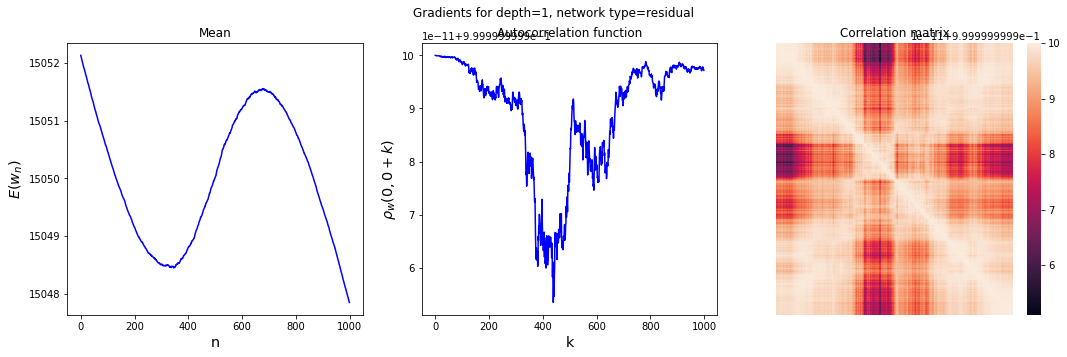

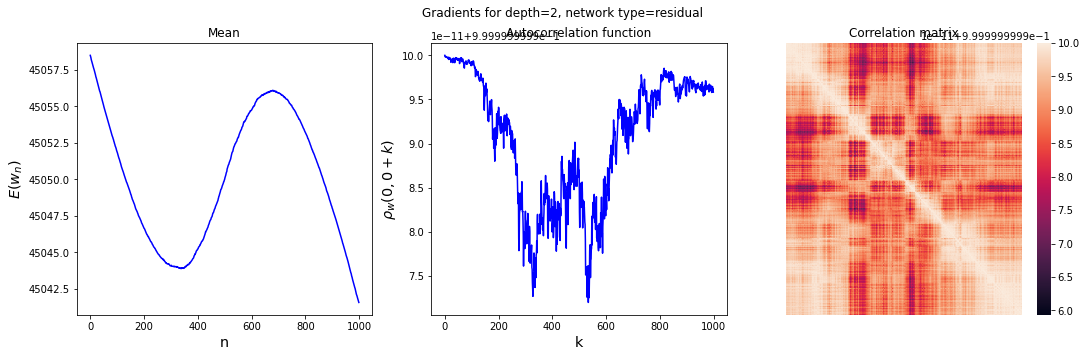

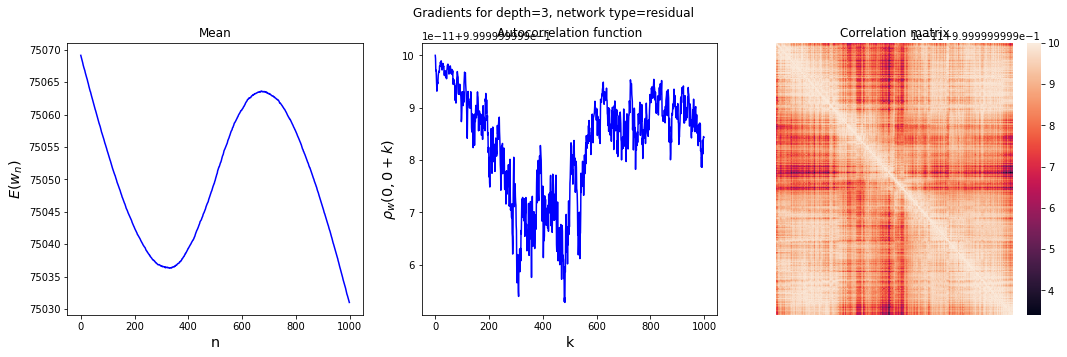

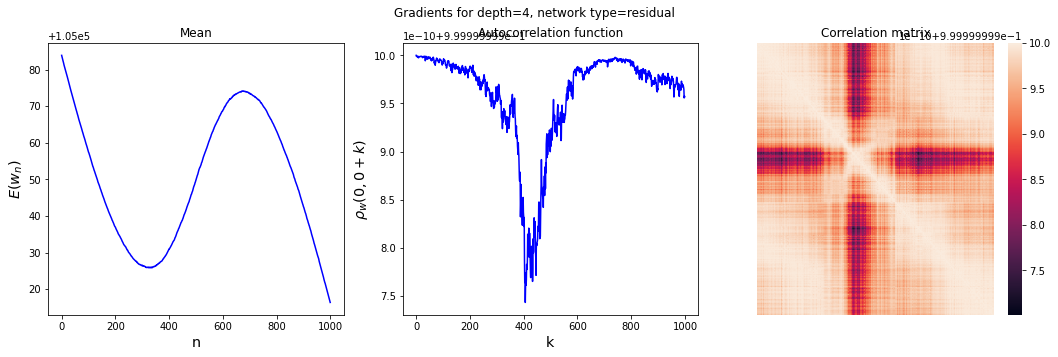

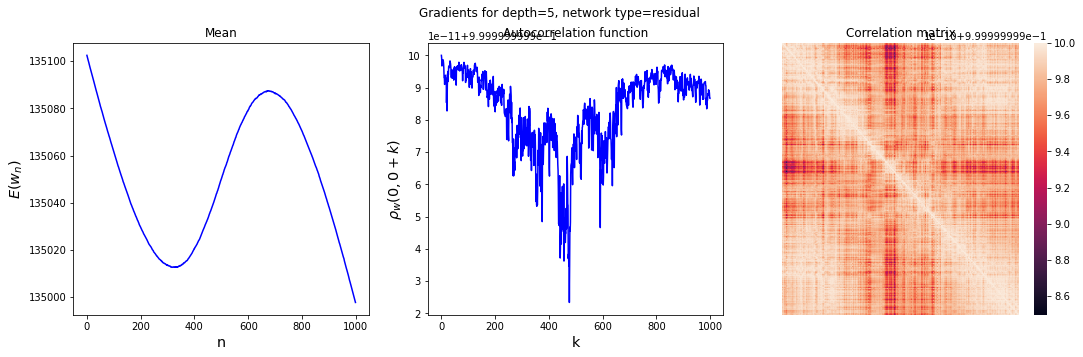

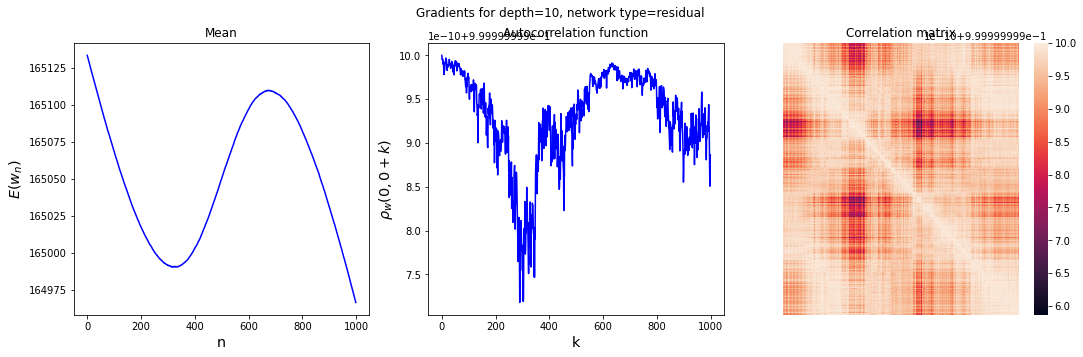

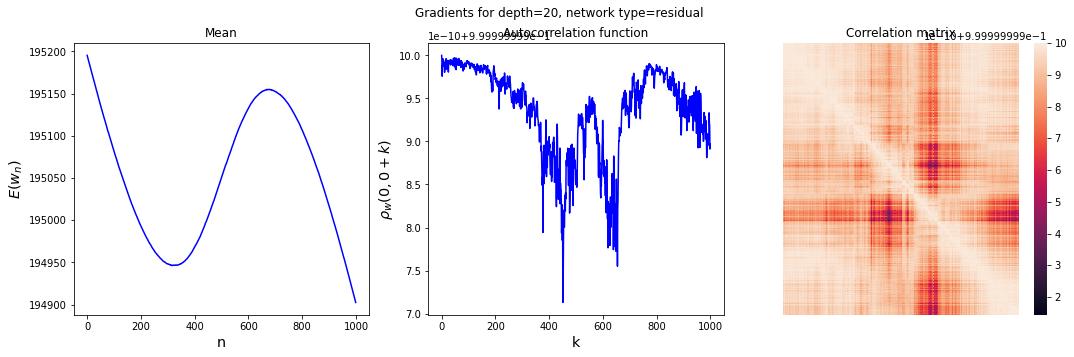

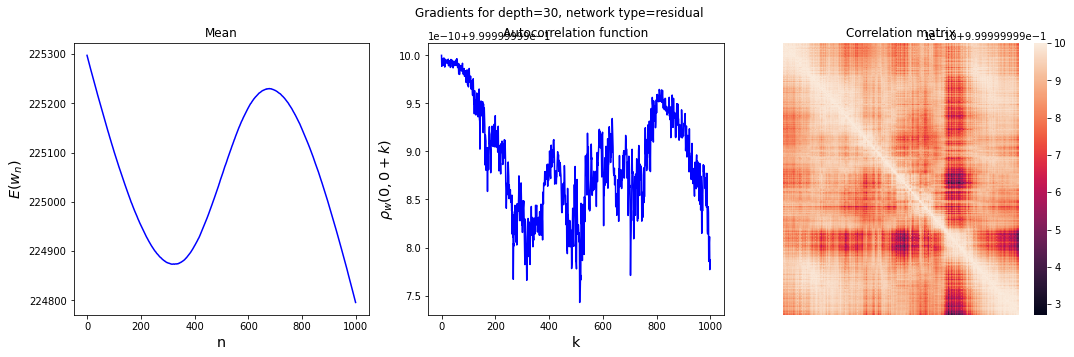

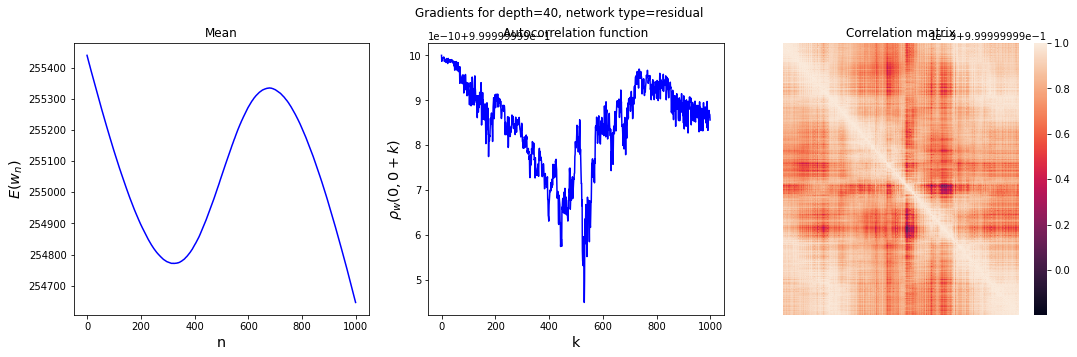

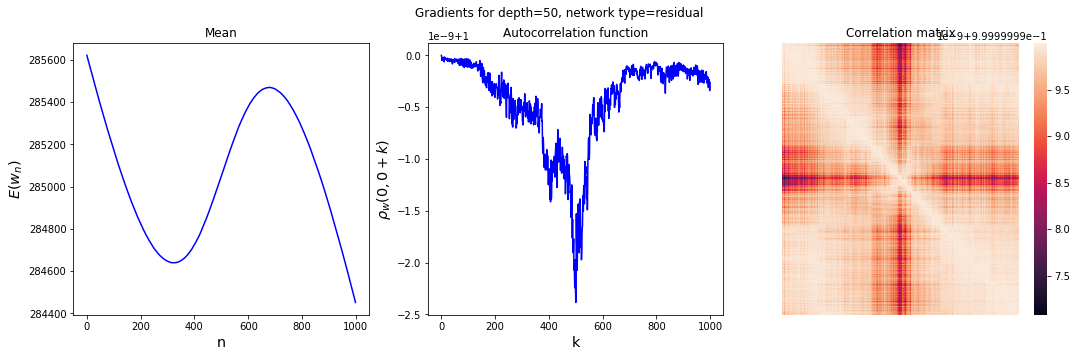

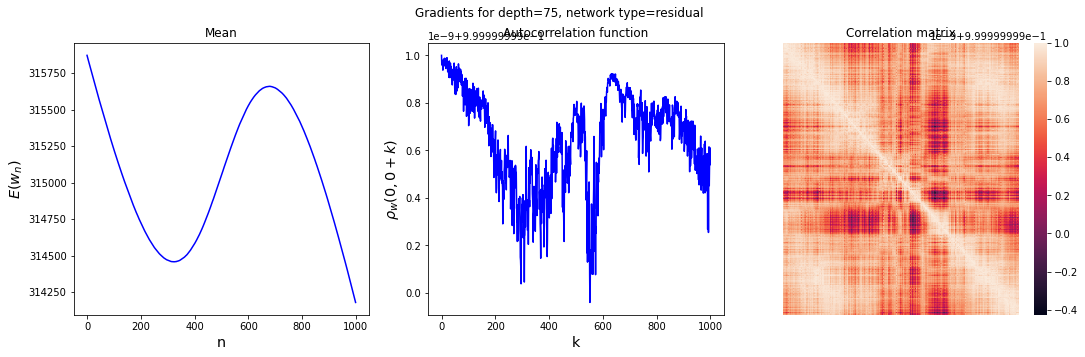

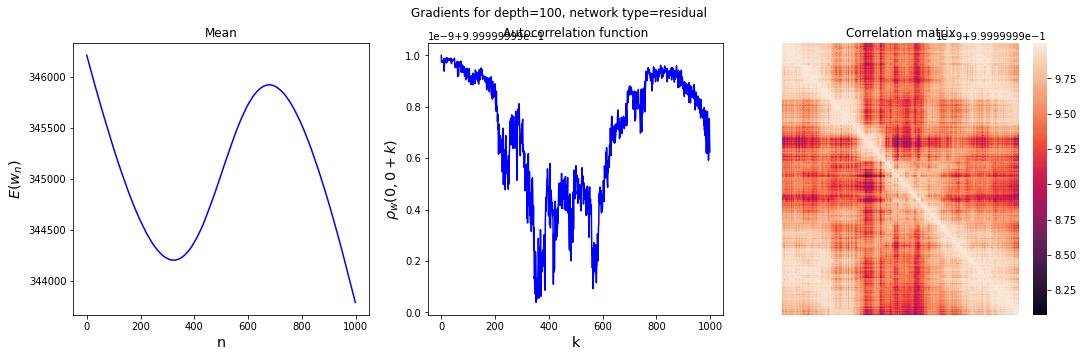

CPU times: user 8min 56s, sys: 24.1 s, total: 9min 21s
Wall time: 9min 22s


In [ ]:
%%time
x = torch.linspace(-1, 1, 1000)
# 4) Visualize gradients wrt x of residual neural networks with various depths.
inspect_gradients(network_type="residual", x=x, depths=[1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 75, 100], num_iters=300, beta=0.01)

5) ANALYSIS OF YOUR RESULTS (in a markdown cell): 
- *Give two problems occuring with the gradients of deep feedforward neural networks at initialization.*
    - Vanishing gradient
        - Gradient is too small (even to store it) after backpropagation though many layers.
        - Similar situation if we calculate big power (~number of layers) of number between 0 and 1.
    - Exploiting gradient
        - Gradient diverge to large number
        - Similar situation if we calculate big power (~number of layers) of number greater than 1.
- From the observation of your plots, to which extent these problems were solved by the combination of proper initialization + batch normalization + skip connections?
    - I am not totally sure about that, I think we should run it without some of the mentioned steps to see what is the difference.
    - It is clear that bad inicialization (e.g. 0 or greater or equal to 1) leads to wrong behavior.
    - However, at least the **skip connections** improve the performance.
    - Autocorrelation is positive in most of cases for the *residual* type of network.

- What is the maximal depth you can reach with your feedforward network before "breaking" the gradients?
    - We can see that for ``depth=50`` it is not stabile. The mean has huge amplitude and the maximal value is reached not in the first (or last) state.
    - To be honest, I am not totally sure about that. I think, the depth 20 or 30 should still work.

- Same question with your residual network.
    - The plot of the mean is quite similar for all tested depths. Only the amplitude differs.
    - That means that it is quite stabile for all depths.
    - Note that we assume using appropriate *beta*.

- What is the effect of the parameter beta in your residual neural network?
    - It represents **weight** for output of the layer.
    - Lower value means that the impact of next layer is small (in comparison to skip connection - i.e. result of previous layer).
    - In the following cell, the effect of different beta is shown.
    - We can see that especially for deep networks, large *beta* (i.e greater or equal to 0.25 - see below) is behaving badly. That confirms the recommendation to use *beta* less or equal to 0.2.

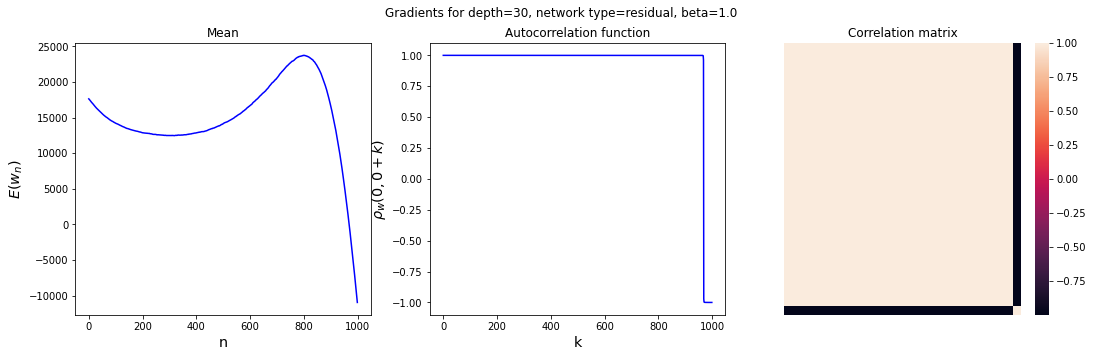

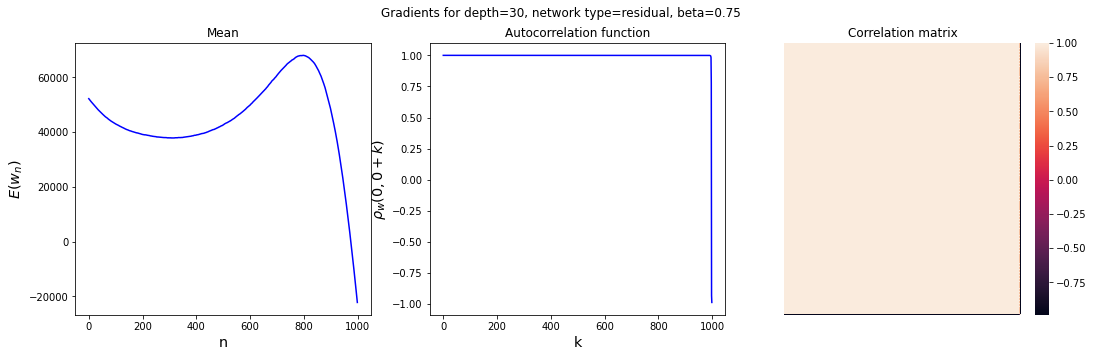

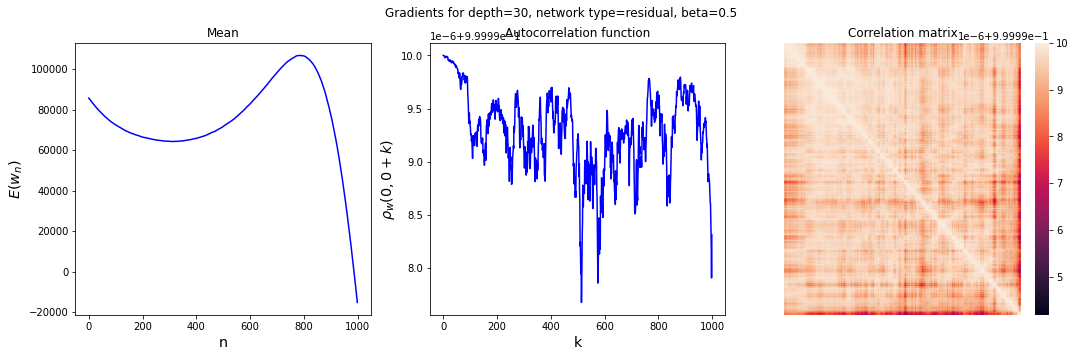

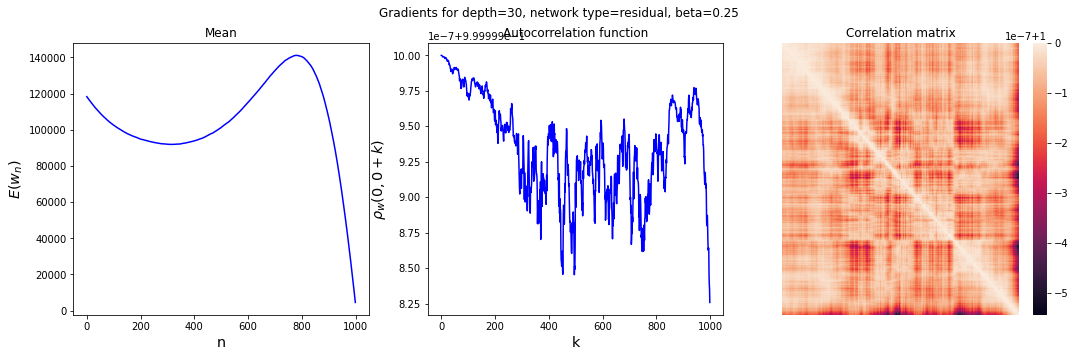

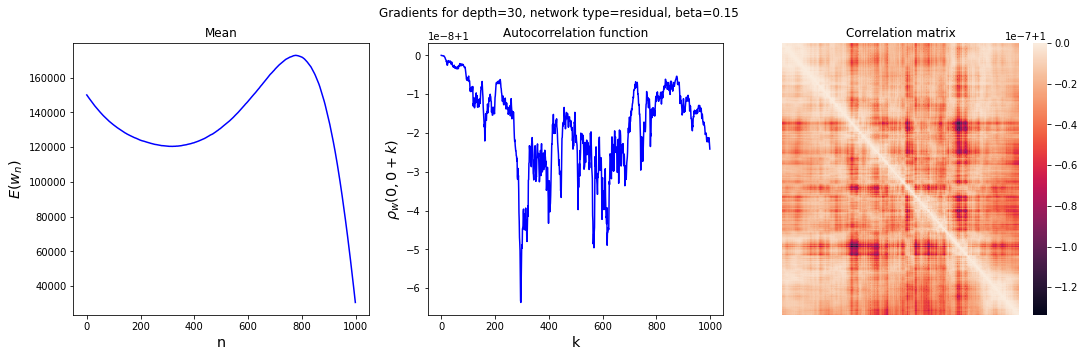

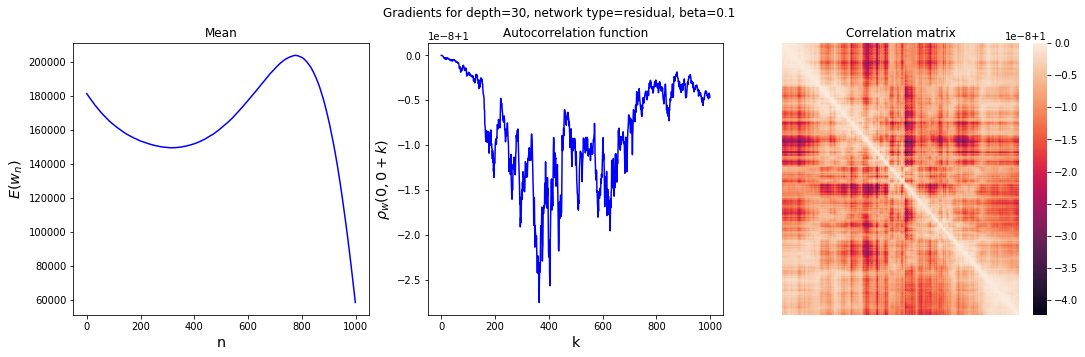

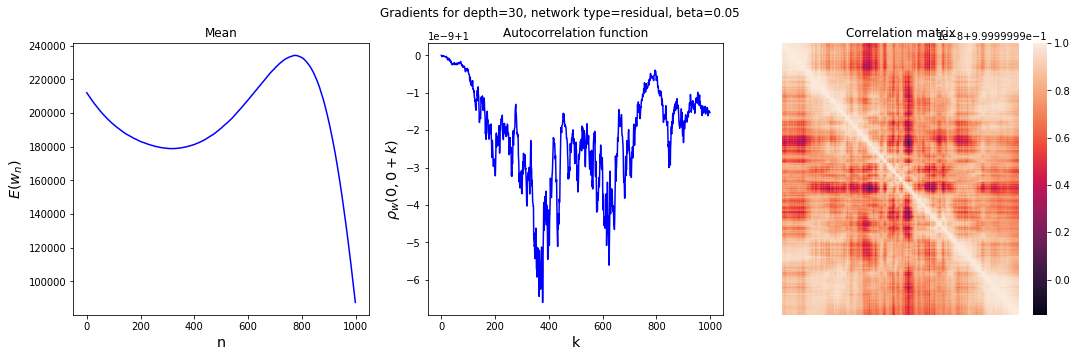

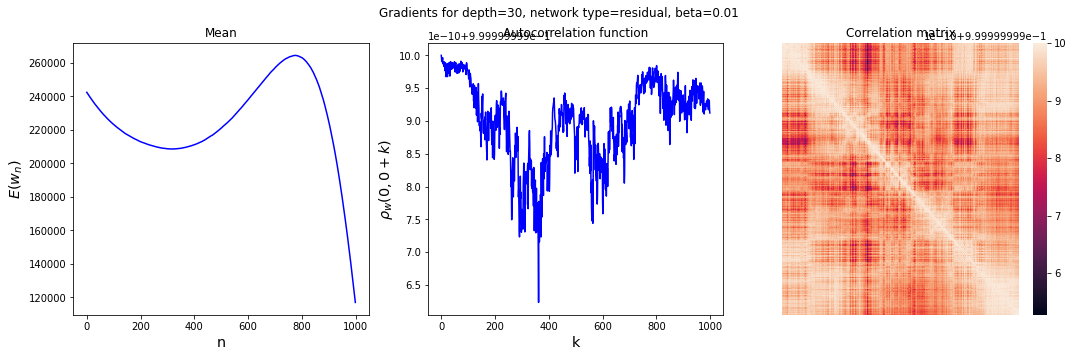

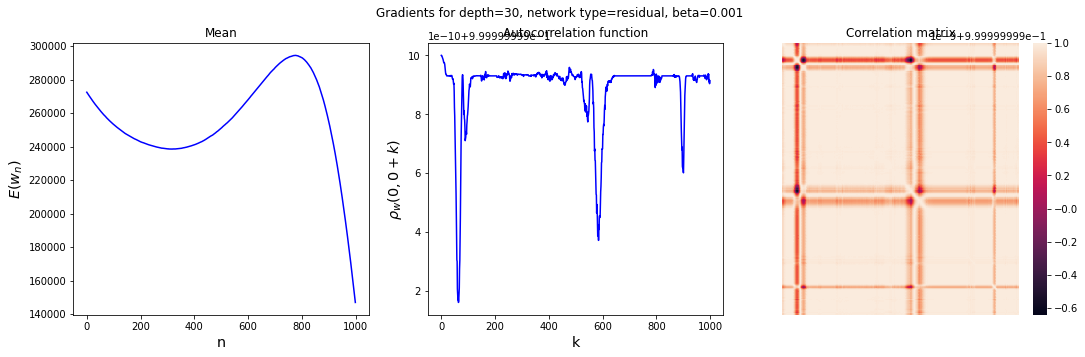

CPU times: user 7min 5s, sys: 18.5 s, total: 7min 23s
Wall time: 7min 24s


In [19]:
%%time
x = torch.linspace(-1, 1, 1000)
# What is the effect of the parameter beta in your residual neural network?
for beta in [1.0, 0.75, 0.5, 0.25, 0.15, 0.1, 0.05, 0.01, 0.001]:
    inspect_gradients(network_type="residual", x=x, depths=[30], num_iters=300, beta=beta)

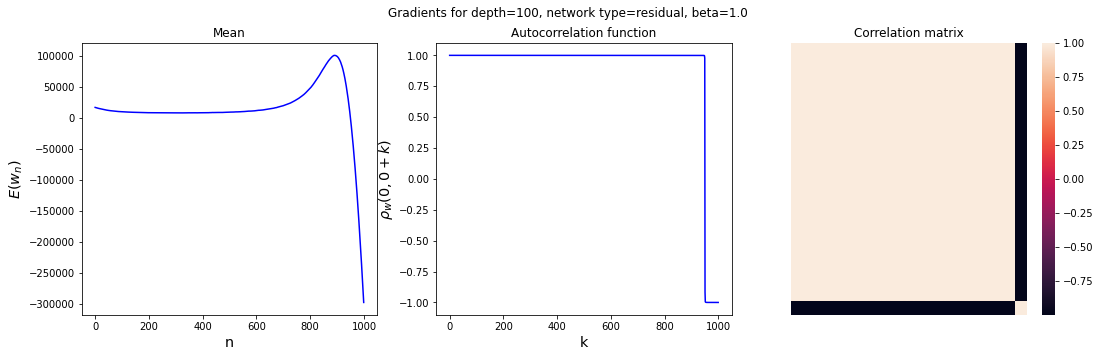

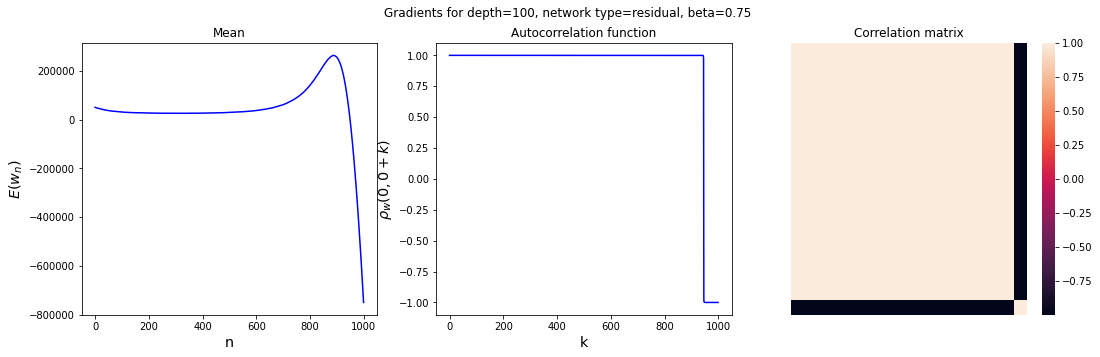

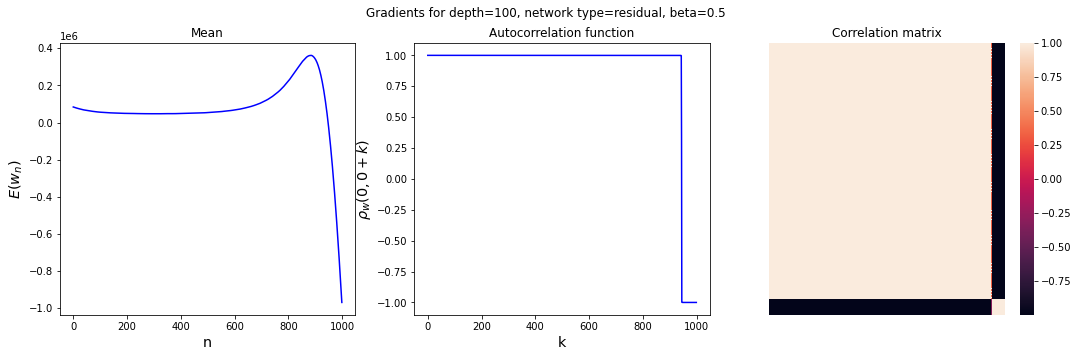

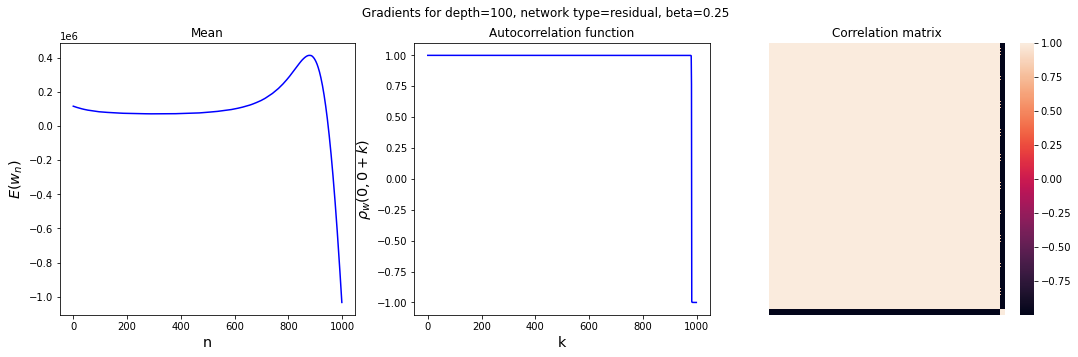

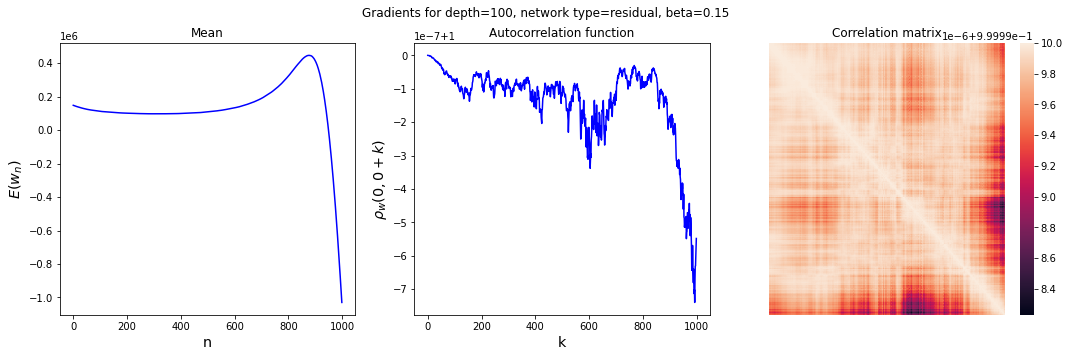

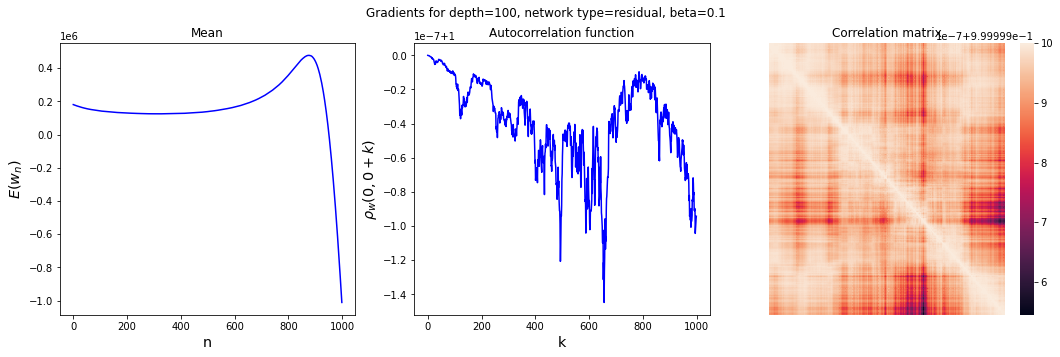

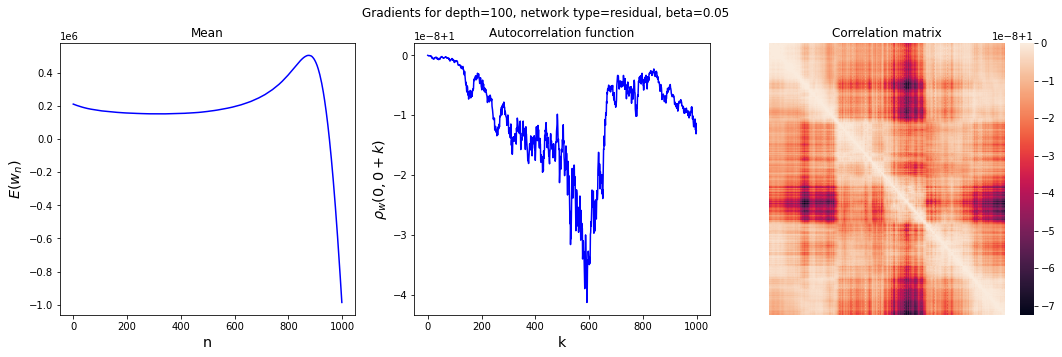

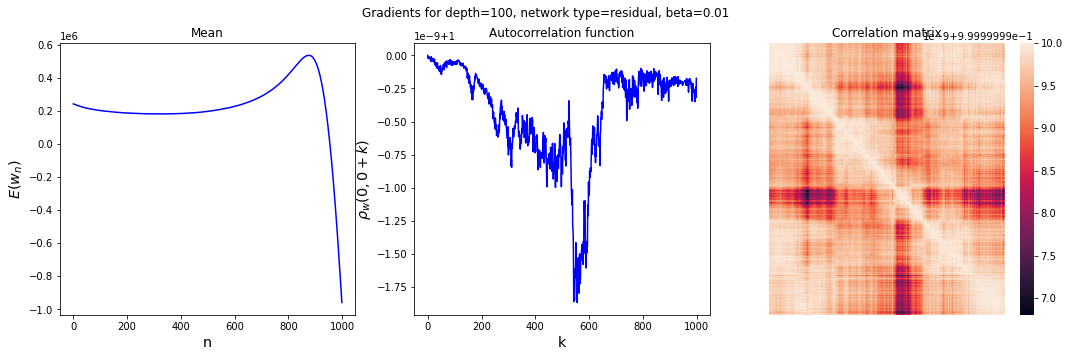

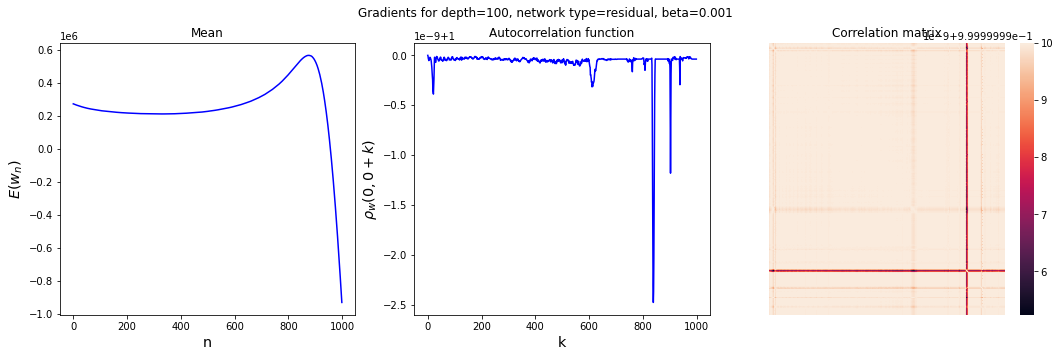

CPU times: user 23min 19s, sys: 1min 19s, total: 24min 39s
Wall time: 24min 43s


In [21]:
%%time
x = torch.linspace(-1, 1, 1000)
# What is the effect of the parameter beta in your residual neural network?
for beta in [1.0, 0.75, 0.5, 0.25, 0.15, 0.1, 0.05, 0.01, 0.001]:
    inspect_gradients(network_type="residual", x=x, depths=[100], num_iters=300, beta=beta)

### Final words...
This assignment was interesting, but
I would be glad for any comment or explanation (e.g. during the friday lecture session).
I hope I got the intuition; however, to be honest, I am not 100% sure if I got it right.

Thanks!

PS: I would appreciate to have some tests for an intermediate results (e.g. what we should get from ``compute_gradient_wrt_input`` function with some random model). I would help me much.